# Detect holes in poles (ha, it rhymes!)

In [7]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

from skimage.morphology import reconstruction, binary_erosion, binary_dilation
from skimage.exposure import rescale_intensity

This notebook is a test of [this hole detection technique](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_holes_and_peaks.html) to see if it helps with detecting holes in the poles, since they can be more difficult to characterize than cracks, which are properly captured by Gabor filters.

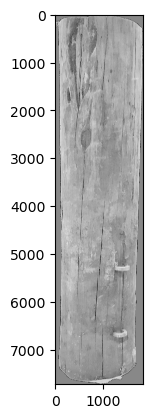

In [4]:
def crop(image):
    y_nonzero, x_nonzero = np.nonzero(image)
    return image[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]

img = cv2.imread(f'../Data/RGB/crops/41_0_crop_masked.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img = np.log(1 + crop(img))
img = rescale_intensity(img)
img = np.where(img == 0, np.mean(img), img)
plt.imshow(img, cmap='gray')

Following this technique, a visualization of holes in all images could be as follows:

In [5]:
def visualize_holes():
    fig, axes = plt.subplots(5, 8, figsize=(20,16))
    pole_ids = ['Ny',30,41,6,5]
    pole_status = ['31/37', '17/24', '15/24', '12/24', '11/24']
    specific_status = ['New', 'Rotten', 'Cracks', 'Cracks', 'Rotten']
    
    data = {
        'id': [0,30,41,6,5],
        'hole_ratio_0_degrees': [],
        'hole_ratio_90_degrees': [],
        'hole_ratio_180_degrees': [],
        'hole_ratio_270_degrees': [],
    }

    for pole_idx, pole_id in enumerate(pole_ids):
        for rotation_idx, rotation in enumerate([0, 90, 180, 270]):
            # Open and preprocess image
            img = cv2.imread(f'../Data/RGB/crops/{pole_id}_{rotation}_crop_masked.jpg')
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = np.log(1 + crop(img))
            img = rescale_intensity(img)
            img = np.where(img == 0, np.mean(img), img)
            
            # Detect holes
            seed = np.copy(img)
            seed[1:-1, 1:-1] = img.max()
            mask = img
            filled = reconstruction(seed, mask, method='erosion')
            diff_img = -img+filled
            diff_img = np.where(diff_img > 0.3, 1, 0)
            
            diff_img = binary_dilation(diff_img, footprint=np.ones((15, 15)))
            diff_img = binary_erosion(diff_img, footprint=np.ones((15, 15)))
            
            axes[pole_idx, rotation_idx*2].imshow(diff_img, cmap='gray')
            axes[pole_idx, rotation_idx*2+1].imshow(img, cmap='gray')
            axes[pole_idx, rotation_idx*2+1].set_xticks([])
            axes[pole_idx, rotation_idx*2+1].set_yticks([])
            
            data[f'hole_ratio_{rotation}_degrees'].append(np.sum(diff_img) / (diff_img.shape[0] * diff_img.shape[1]))

    fig.suptitle('Hole detection')

    [axes[0,i*2].set_title(f'{i*90} degrees') for i in range(4)]

    [axes[i,0].set_ylabel(f'Pole {pole}\nStatus: {pole_status[i]}\nCause: {specific_status[i]}', labelpad=60, fontdict={'rotation':0}) for i, pole in enumerate(pole_ids)]

    plt.savefig('../Figures/morph_reconstruction.jpg')
    
    return data

In [6]:
data = visualize_holes()
df_morph = pd.DataFrame(data)
df_morph.to_csv(f'../Features/morphological.csv')